<a href="https://colab.research.google.com/github/JYW5114/TTC_delay/blob/main/TTC_Bus_Delays_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**TTC Bus Delays**

This file contains code for the statistical models and data visualisations tools we use to estimate the (1) time and (2) location of TTC Bus's delay and also (3) the reasons of delay.

*The goal of this file is to be able to forecast the time of delay, given the  time and location of departure within the Bus TTC network.*

#####**Data Description**
The dataset sourced from the Open Data Toronto. The data are recorded by the Toronto Transit Commission throughout 2024. The dataset contains a records of transit delays by the Bus TTC, including the time of delay, location of the delay-causing, indicent and others and many others.

In [1]:
# import libaries
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import clear_output

# import file
from google.colab import files
uploaded = files.upload()

Saving bus-data.csv to bus-data.csv


In [3]:
# read csv file
data = pd.read_csv(io.BytesIO(uploaded['bus-data.csv']), sep = ',')
data.head()

,Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle
0,1-Jan-24,89,02:08,Monday,KEELE AND GLENLAKE,Vision,10,20,N,7107
1,1-Jan-24,39,02:30,Monday,FINCH STATION,General Delay,20,40,NaN,8914
2,1-Jan-24,300,03:13,Monday,BLOOR AND MANNING,General Delay,0,0,NaN,8562
3,1-Jan-24,65,03:23,Monday,PARLIAMENT AND BLOOR,Security,0,0,N,8574
4,1-Jan-24,113,03:37,Monday,MAIN STATION,Security,0,0,NaN,8541


#####**Data Cleaning**

We remove data records that have missing values in time, min delay, location and incident as these are the variables we will be using in our model. Removing these datas won't affect our result much due to our large diverse dataset.

In [5]:
data = data.replace('?', np.nan)
data = data.replace(' ', np.nan)
data = data[data['Min Delay'] > 1]
for col in ['Time', 'Min Delay','Location', 'Incident']:
  data = data.dropna(subset=[col])

#####**PART I**

Here we will be plotting the time of delay against average delay time (in minutes) in a day

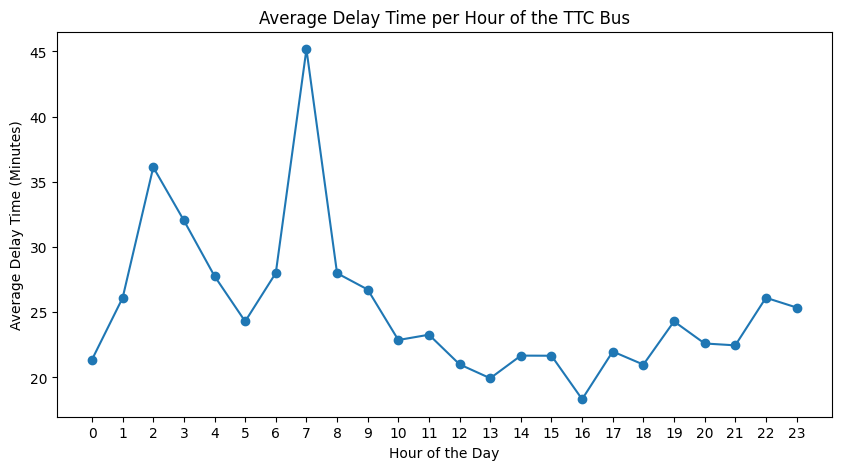

In [6]:
data["Hour"] = data["Time"].str[:2].astype(int)
avg_delay_per_hour = data.groupby("Hour")["Min Delay"].mean()

# Plotting the line plot
plt.figure(figsize=(10, 5))
plt.plot(avg_delay_per_hour.index, avg_delay_per_hour.values, marker='o')

plt.xlabel("Hour of the Day")
plt.ylabel("Average Delay Time (Minutes)")
plt.title("Average Delay Time per Hour of the TTC Bus")
plt.xticks(range(24))
plt.show()

#####**PART II**

Here we are plotting the top 20 TTC Bus locations with the most delays.

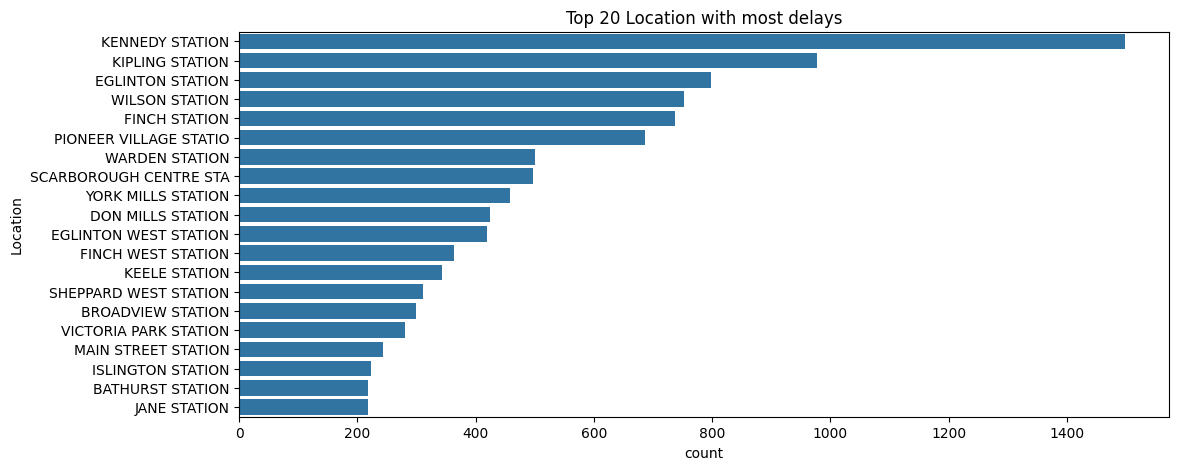

In [7]:
# Plot Bar Graph
plt.figure(figsize=(12,5))
sns.countplot(y=data['Location'], order= data['Location'].value_counts().iloc[:20].index);
plt.title("Top 20 Location with most delays");

#####**PART III**

Here we will be plotting the reasons of incident against its average delay time (in minutes) in a day

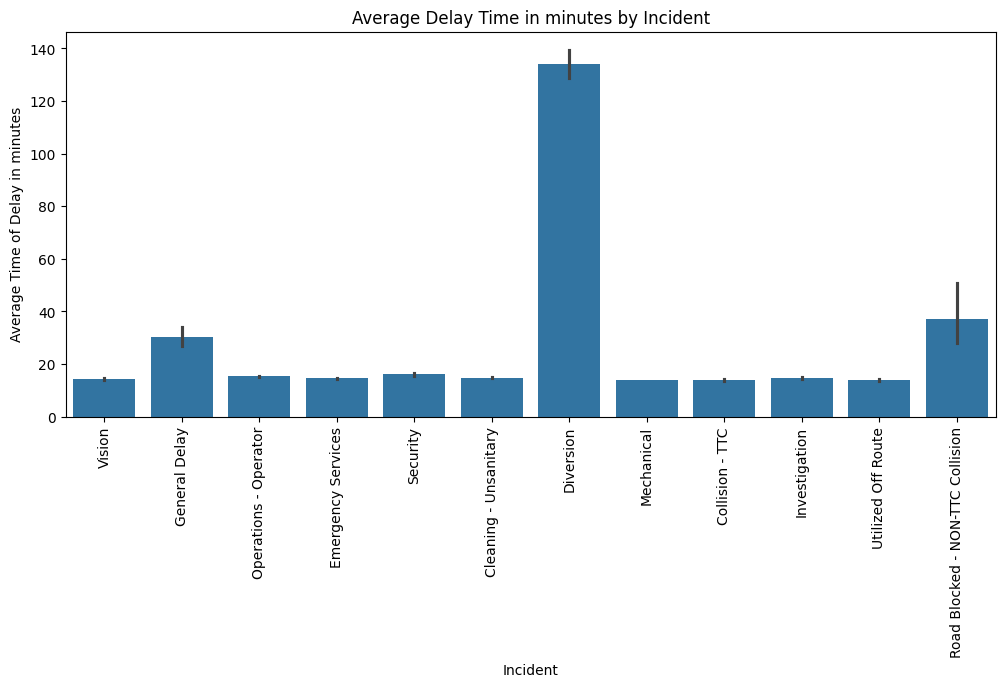

In [9]:
# Plot Bar Graph
plt.figure(figsize=(12,5))
sns.barplot(x='Incident', y='Min Delay', data= data);
plt.title("Average Delay Time in minutes by Incident")
plt.xlabel("Incident")
plt.ylabel("Average Time of Delay in minutes");
plt.xticks(rotation= 90);

###**Predictive Model**

This model takes in time and location of departure and returns a time estimation of delay in minutes.

In [10]:
data["Hour"] = data["Time"].str[:2].astype(int)
avg_delay_per_hour = data.groupby("Hour")["Min Delay"].mean()

def add_widget(location, time):
  location_widget = widgets.Dropdown(
      options=sorted([(c, c) for c in data['Location'].unique()]),
      value=location,
      description='Location:',
  )

  time_widget = widgets.Dropdown(
      options=sorted([(c, c) for c in data['Hour'].unique()]),
      value= int(time),
      description='Hour:',
  )

  location_widget.observe(lambda d: predict(location_widget.value, time_widget.value), 'value')
  time_widget.observe(lambda d: predict(location_widget.value, time_widget.value), 'value')
  display(location_widget, time_widget)

def predict(location, time):
  clear_output()
  add_widget(location, time)
  filtered_data = data[(data['Location'] == location) & (data['Hour'] == time)]
  if not filtered_data.empty:
    avg_delay = filtered_data['Min Delay'].mean()
  else:
    prev_hour = data[(data['Location'] == location) & (data['Hour'] < time)]['Hour'].max()
    next_hour = data[(data['Location'] == location) & (data['Hour'] > time)]['Hour'].min()
    prev_data = data[(data['Location'] == location) & (data['Hour'] == prev_hour)]
    next_data = data[(data['Location'] == location) & (data['Hour'] == next_hour)]
    avg_delay = (prev_data['Min Delay'].mean() + next_data['Min Delay'].mean()) / 2

  print(f"Predicted Delay at {location} at {time}:00 is {avg_delay:.2f} minutes")

add_widget(location = "FINCH STATION", time = 2)

Dropdown(description='Location:', index=3069, options=(('$0 RIVALDA RD', '$0 RIVALDA RD'), ('1 CARLTON ST', '1…

Dropdown(description='Hour:', index=14, options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7…

Predicted Delay at FINCH STATION at 14:00 is 9.91 minutes
